# Reflection and Transmission Coefficients

## Name : YOUR NAME

## Date : THE DATE

In this assignment the reflection coefficients and phases will be analyzed for the P-SV and SH system.  


In [1]:
# Imports
import matplotlib.pyplot as plt
from cmath import sqrt as csqrt
from numpy import sin, cos, radians, angle, pi, arcsin
from numpy import zeros
from numpy import linspace

# Utility Functions

Below are a series of utility functions.  These scripts compute the reflection and transmission coefficients in Table3.1 of Lay and Wallace's Modern Global Seismology (1995).  The terms have been corrected and are consistent with a subset of formulas from Aki and Richards' Quantitative Seismology (2002). 

In [2]:
def incidenceAngleToRayParameter(i, vel):
    """
    Converts incidence angles to ray parameters.
    
    Input
    -----
    i : array_like
        Array of incidence angles in degrees.  These must be in range [0,90].
        
    vel : float
        Phase velocity (km/s) of layer.
        
    Returns
    -------
    p : array_like
       Array of horizontal slownesses (s/km) corresponding to input incidence angles.
       
    Copyright
    ---------
    Ben Baker distributed under the MIT license.
    
    """
    if (vel <= 0.0):
        print("Error - velocity %f must be positive"%vel)
    if (min(i) < 0.0 or max(i) > 90.0):
        print("Warning - some incidence angles may be out of bounds [0,90]")
    p = sin(radians(i))/vel
    return p

def computeVerticalSlowness(p, c):
    """
    Computes the vertical slowness given the ray parameter and layer phase velocity. 
    
    Input
    -----
    p : array_like 
      Horizontal slowness (s/km)
    c : float 
      Phase velocity of layer (s/km)
    
    Returns
    -------
    eta : array_like 
        The vertical slowness (s/km) for all corresponding ray parameters.
    
    Copyright
    ---------
    Ben Baker distributed under the MIT license.
    
    """
    eta = zeros(len(p), dtype='complex')
    for i in range(len(p)):
        eta[i] = csqrt(1.0/(c**2) - p[i]**2)
    return eta

def computeCriticalAngle(c1, c2):
    """
    Computes the critical angle - the angle at which the head-wave transmits energy back into
    the upper layer.  This is Equation 3.41 of Lay and Wallace.
    
    Input
    -----
    c1 : float 
       Velocity (km/s) in upper layer.
    c2 : float: 
       Velocity (km/s) in lower layer.
    
    
    Returns
    -------
    criticalAngle : float or None
       The critical angle in degrees.  If c2 < c1 then this returns None.
    
    Copyright
    ---------
    Ben Baker distributed under the MIT license.   
    
    """
    if (c2 < c1):
        return None
    criticalAngle = arcsin(c1/c2)*180.0/pi
    return criticalAngle

def computeRTCoeffs(p, alpha1, beta1, rho1, alpha2, beta2, rho2):
    """
    Computes the reflection and transmission coefficients for the P-SV system.
    Here it is assumed that the incident phase is approaching in the 1 layer.
    This uses the coefficients from Lay and Wallace Table 3.1 but with appropriate
    corrections as outlined by Aki and Richards. 
    
    Input
    -----
    p : array_like
        Ray parameter (s/km).
    alpha1 : float
        Compressional velocity (km/s) in upper layer.
    beta1 : float
        Shear velocity (km/s) in lower layer.
    rho1 : float
        Density (g/cm**3) in upper layer.
    alpha2 : float
        Compressional velocity (km/s) in lower layer.
    beta2 : float
        Shear velocity (km/s) in lower layer.
    rho2 : float
        Density (g/cm**3) in lower layer.
        
    Returns
    -------
    RPP_PSV : array_like
        Coefficient for incident P to reflected P.
    RPS_PSV : array_like
        Coefficient for incident P to reflected SV.
    TPP_PSV : array_like
        Coefficient for incident P to transmitted SV.
    TPS_PSV : array_like
        Coefficient for incident P to transmitted P.
    RSS_PSV : array_like
        Coefficient for incident SV to reflected SV.
    RSP_PSV : array_like 
        Coefficient for incident SV to reflected P.
    TSS_PSV : array_like
        Coefficient for incident SV to transmitted SV.
    TSP_PSV : array_like
        Coefficient for incident SV to transmitted P. 
        
    Copyright
    ---------
    Ben Baker distributed under the MIT license.
    
    """
    # Annoy the users with warnings
    if (alpha1 < beta1):
        print("Error - alpha1 = %f < beta1 %f"%(alpha1,beta1))
    if (alpha2 < beta2):
        print("Error - alpha2 = %f < beta2 %f"%(alpha2,beta2))
    if (alpha1 <= 0.0 or alpha2 <= 0.0 or rho1 <= 0.0 or rho2 <= 0.0):
        print("Error all material properties must be positive (%f,%f,%f,%f)"%(alpha1,alpha2,rho1,rho2))
    #p = sin(radians(i))/alpha1
    beta12 = beta1*beta1 # Shear wave velocity squared in upper layer
    beta22 = beta2*beta2 # Shear wave velocity squared in lower layer
    p2 = p**2 # Ray parameter squared
    eta_alpha1 = computeVerticalSlowness(p, alpha1)
    eta_beta1  = computeVerticalSlowness(p, beta1)
    eta_alpha2 = computeVerticalSlowness(p, alpha2)
    eta_beta2  = computeVerticalSlowness(p, beta2)     
    #A = ((1.0/beta2 - 2.*p2) - 2.0*p2)**2 + 4.0*p2*eta_alpha1*eta_beta1
    a = rho2*(1.0 - 2.0*beta22*p2) - rho1*(1.0 - 2.0*beta12*p2)
    b = rho2*(1.0 - 2.0*beta22*p2) + 2.0*rho1*beta12*p2 # Lay and Wallace is wrong - sign fator
    c = rho1*(1.0 - 2.0*beta12*p2) + 2.0*rho2*beta22*p2
    d = 2.0*(rho2*beta22 - rho1*beta12)
    E = b*eta_alpha1 + c*eta_alpha2
    F = b*eta_beta1  + c*eta_beta2
    G = a - d*eta_alpha1*eta_beta2
    H = a - d*eta_alpha2*eta_beta1 
    D = E*F + G*H*p2 # Denominator

    # P/SV reflection/transmission
    RPP_PSV = ( (b*eta_alpha1 - c*eta_alpha2)*F - (a + d*eta_alpha1*eta_beta2)*H*p2 )/D
    RPS_PSV =-( 2.0*eta_alpha1*(a*b + c*d*eta_alpha2*eta_beta2)*p*(alpha1/beta1) )/D
    TPP_PSV = ( 2.0*rho1*eta_alpha1*F*(alpha1/alpha2) )/D
    TPS_PSV = ( 2.0*rho1*eta_alpha1*H*p*(alpha1/beta2) )/D
    RSS_PSV =-( (b*eta_beta1 - c*eta_beta2)*E - (a + d*eta_alpha2*eta_beta1)*G*p2 )/D # Lay and Wallace is wrong - d not b
    RSP_PSV =-( 2.0*eta_beta1*(a*b + c*d*eta_alpha2*eta_beta2)*p*(beta1/alpha1) )/D
    TSP_PSV =-( 2.0*rho1*eta_beta1*G*p*(beta1/alpha2) )/D
    TSS_PSV = ( 2.0*rho1*eta_beta1*E*(beta1/beta2) )/D

    return [RPP_PSV, RPS_PSV, TPP_PSV, TPS_PSV, 
            RSS_PSV, RSP_PSV, TSS_PSV, TSP_PSV]

def computeRTCoeffs_incidentP(i, alpha1, beta1, rho1, alpha2, beta2, rho2):
    """
    Computes the reflection and transmission coefficients for the P-SV system for an incident P 
    wave in the first layer at a range of incidene angles.

    Input
    -----
    i : array_like
        Incidence angles (degrees).  Each value must be in the range of [0,90] degrees.
    alpha1 : float
        Compressional velocity (km/s) in upper layer.
    beta1 : float
        Shear velocity (km/s) in lower layer.
    rho1 : float
        Density (g/cm**3) in upper layer.
    alpha2 : float
        Compressional velocity (km/s) in lower layer.
    beta2 : float
        Shear velocity (km/s) in lower layer.
    rho2 : float
        Density (g/cm**3) in lower layer.
        
    Returns
    -------
    RPP_PSV : array_like
        Complex coefficients for incident P to reflected P corresponding to incidence angles.
    RPS_PSV : array_like
        Complex coefficients for incident P to reflected SV corresponding to incidence angles.
    TPP_PSV : array_like
        Complex coefficients for incident P to transmitted SV corresponding to incidence angles.
    TPS_PSV : array_like
        Complex coefficients for incident P to transmitted P corresponding to incidence angles.

    Copyright
    ---------
    Ben Baker distributed under the MIT license.
    
    """    
    p = incidenceAngleToRayParameter(i, alpha1) #p = sin(radians(i))/alpha1
    [RPP_PSV, RPS_PSV, TPP_PSV, TPS_PSV, 
     RSS_PSV, RSP_PSV, TSS_PSV, TSP_PSV] = computeRTCoeffs(p, alpha1, beta1, rho1, alpha2, beta2, rho2)
    return [RPP_PSV, RPS_PSV, TPP_PSV, TPS_PSV]
    
def computeRTCoeffs_incidentSV(i, alpha1, beta1, rho1, alpha2, beta2, rho2):
    """
    Computes the reflection and transmission coefficients for the P-SV system for an incident SV 
    wave in the first layer at a range of incidene angles.

    Input
    -----
    i : array_like
        Incidence angles (degrees).  Each value must be in the range of [0,90] degrees.
    alpha1 : float
        Compressional velocity (km/s) in upper layer.
    beta1 : float
        Shear velocity (km/s) in lower layer.
    rho1 : float
        Density (g/cm**3) in upper layer.
    alpha2 : float
        Compressional velocity (km/s) in lower layer.
    beta2 : float
        Shear velocity (km/s) in lower layer.
    rho2 : float
        Density (g/cm**3) in lower layer.
        
    Returns
    -------
    RSS_PSV : array_like
        Complex coefficients for incident SV to reflected SV corresponding to incidence angles.
    RSP_PSV : array_like 
        Complex coefficients for incident SV to reflected P corresponding to incidence angles.
    TSS_PSV : array_like
        Complex coefficients for incident SV to transmitted SV corresponding to incidence angles.
    TSP_PSV : array_like
        Complex coefficients for incident SV to transmitted P corresponding to incidence angles. 

    Copyright
    ---------
    Ben Baker distributed under the MIT license.
    
    """       
    p = incidenceAngleToRayParameter(i, beta1) #p = sin(radians(i))/beta1
    [RPP_PSV, RPS_PSV, TPP_PSV, TPS_PSV, 
     RSS_PSV, RSP_PSV, TSS_PSV, TSP_PSV] = computeRTCoeffs(p, alpha1, beta1, rho1, alpha2, beta2, rho2)
    return [RSS_PSV, RSP_PSV, TSS_PSV, TSP_PSV]

def computeRTCoeffs_incidentSH(i, beta1, rho1, beta2, rho2):
    """
    Computes the reflection and transmission coefficients for the SH system for an incident SH 
    wave in the first layer at a range of incidene angles.

    Input
    -----
    i : array_like
        Incidence angles (degrees).  Each value must be in the range of [0,90] degrees.
    beta1 : float
        Shear velocity (km/s) in lower layer.
    rho1 : float
        Density (g/cm**3) in upper layer.
    beta2 : float
        Shear velocity (km/s) in lower layer.
    rho2 : float
        Density (g/cm**3) in lower layer.
        
    Returns
    -------
    RSS_SH : array_like
        Complex coefficients for incident SH to reflected SH corresponding to incidence angles.
    TSS_SH : array_like 
        Complex coefficients for incident SH to transmitted SH corresponding to incidence angles.

    Copyright
    ---------
    Ben Baker distributed under the MIT license.
    
    """        
    # SH reflection/transmission
    p = incidenceAngleToRayParameter(i, beta1) #p = sin(radians(i))/beta1
    eta_beta1  = computeVerticalSlowness(p, beta1)
    eta_beta2  = computeVerticalSlowness(p, beta2)
    beta12 = beta1*beta1
    beta22 = beta2*beta2
    mu1 = rho1*beta12 
    mu2 = rho2*beta22
    RSS_SH = (mu1*eta_beta1 - mu2*eta_beta2)/(mu1*eta_beta1 + mu2*eta_beta2)
    TSS_SH = 2.0*mu1*eta_beta1/(mu1*eta_beta1 + mu2*eta_beta2)
    return [RSS_SH, TSS_SH]



# Shearer Figure 6.4 Example

## Question - What is the critical angle?

PUT YOUR ANSWER HERE (You may also modify the script below and compute this)

## Question - What is the polarity of a reflected wave at $30^\circ$?

Assume an SH wave with _negative_ polarity hits the Moho at $30^\circ$ and propagtes back to the surface where it will be recorded.  Will the recorded reflected wave polarity be positive or negative?

PUT YOUR ANSWER HERE

## Question - Can there be an evenascent wave  in the crust?

Assume an SH wave hits the interface with a $45^\circ$ incidence angle.  Can an evanescent wave be generated in the crust?

PUT YOUR ANSWER HERE

## Question  - Past the critical angle how much energy is transmitted into the mantle?

Beware - it's a trap.

PUT YOUR ANSWER HERE.


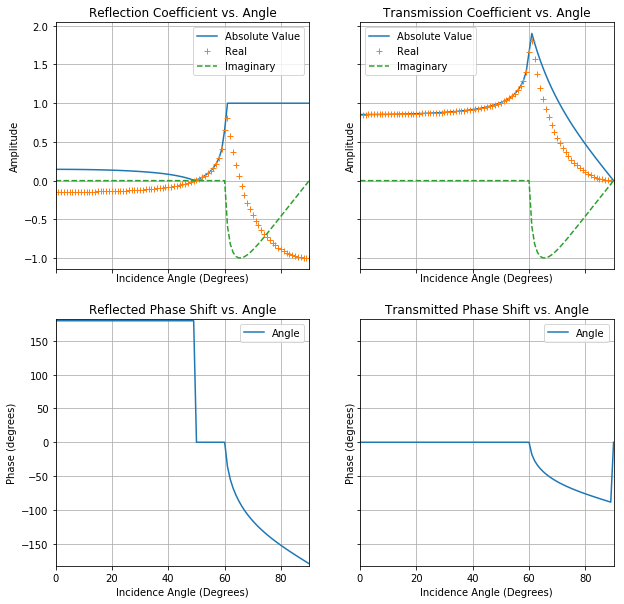

In [3]:
def makeAngleFigure(ax, i, R, title='Reflected Phase Shift vs. Angle'):
    ax.plot(i, angle(R)*180.0/pi, label='Angle')
    ax.set_title(title)
    ax.set_ylabel('Phase (degrees)') 
    ax.set_xlabel('Incidence Angle (Degrees)')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(xmin=0.0, xmax=90.0)
    ax.set_ylim(ymin=-183.0, ymax=183.0)
    return 

def makeReflectionFigure(ax, i, R, title='Reflection Coefficient vs. Angle'):
    ax.plot(i, abs(R), label='Absolute Value')
    ax.plot(i, R.real, '+',  label='Real')
    ax.plot(i, R.imag, '--', label='Imaginary')
    ax.set_title(title)
    ax.set_ylabel('Amplitude') 
    ax.set_xlabel('Incidence Angle (Degrees)')    
    ax.set_xlim(xmin=0.0, xmax=90.0)
    ax.legend()
    ax.grid(True)
    return 

def makeShearerFigure6_4():
    """
    This is an example of how to make the Figure 6.4 in the Shearer textbook.
    """
    beta1 = 3.9   # S velocity in lower crust (km/s)
    rho1  = 2.9   # Density in lower crust (g/cm**3)
    beta2 = 4.49  # S velocity in mantle (km/s)
    rho2  = 3.38  # Density in mantle (g/cm**3)
    # Define the angles
    i = linspace(0.0, 90.0, 91)
    # Compute thax1e SH coefficients for an incident SH wave in the crust.
    [RSS_SH, TSS_SH] = computeRTCoeffs_incidentSH(i, beta1, rho1, beta2, rho2)
   
    plt.close('all')
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10,10))

    makeReflectionFigure(ax1, i, RSS_SH, title='Reflection Coefficient vs. Angle')
    makeReflectionFigure(ax2, i, TSS_SH, title='Transmission Coefficient vs. Angle')

    makeAngleFigure(ax3, i, RSS_SH, title='Reflected Phase Shift vs. Angle')
    makeAngleFigure(ax4, i, TSS_SH, title='Transmitted Phase Shift vs. Angle')
    
    plt.show()

    return

makeShearerFigure6_4()

# Reflection and Transmission at the Core Mantle Boundary

We can use our reflection/transmission coefficient routines to look at scattering at the core-mantle boundary.


## Question - suppose your receiver was directly above the source so that the incidence angle is $0^\circ$ - would you expect a large reflection?

PUT YOUR ANSWER HERE

## Question - is there are part of this result that is not sensible?

PUT YOUR ANSWER HERE

## Question - if part of the result is not sensible then what correction would you make to your physical description of the problem?

PUT YOUR ANSWER HERE


35.9772203427


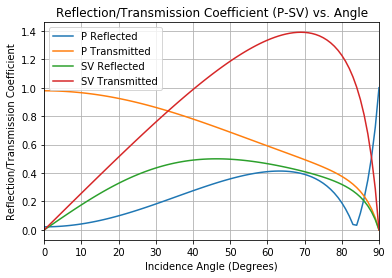

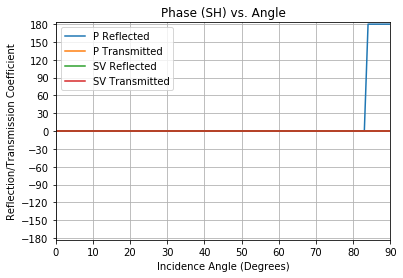

In [4]:
vp1  = 13.72 # Compressional velocity in lower mantle (km/s)
vs1  = 7.26  # Shear velocity in lower mantle (km/s)
rho1 = 5.57  # Density in lower mantle (g/cm**#)
vp2  = 8.06  # Compressional velocity in outer-core
vs2  = 0.001# Shear wave velocity in outer-core - Make it small so nothing blows up
rho2 = 9.9   # Density in the core (g/cm**3)

# Define the angles
i = linspace(0.0, 90.0, 91)

# Compute the P-SV coefficients for an incident P wave at the CMB
[RPP_PSV, RPS_PSV, TPP_PSV, TPS_PSV] = computeRTCoeffs_incidentP(i,
                                                                 vp1, vs1, rho1, 
                                                                 vp2, vs2, rho2)
print(computeCriticalAngle(vp2, vp1))
plt.plot(i, abs(RPP_PSV), label='P Reflected')
plt.plot(i, abs(TPP_PSV), label='P Transmitted')
plt.plot(i, abs(RPS_PSV), label='SV Reflected')
plt.plot(i, TPS_PSV.real, label='SV Transmitted')
#plt.plot(i, abs(TPP_PSV), label='TPP')
#plt.plot(i, abs(TPS_PSV), label='TPS')
plt.title('Reflection/Transmission Coefficient (P-SV) vs. Angle')
plt.ylabel('Reflection/Transmission Coefficient')
plt.xlabel('Incidence Angle (Degrees)')
plt.legend()
plt.xticks(linspace(0,90, 10))
plt.xlim(xmin=0.0, xmax=90.0)
plt.grid(True)
plt.show()

plt.plot(i, angle(RPP_PSV)*180.0/pi, label='P Reflected')
plt.plot(i, angle(TPP_PSV)*180.0/pi, label='P Transmitted')
plt.plot(i, angle(RPS_PSV)*180.0/pi, label='SV Reflected')
plt.plot(i, angle(TPS_PSV)*180.0/pi, label='SV Transmitted')
plt.xticks(linspace(0,90, 10))
plt.yticks(linspace(-180,180, 13))
plt.xlim(xmin=0.0, xmax=90.0)
plt.ylim(ymin=-183.0, ymax=183.0)
plt.title('Phase (SH) vs. Angle')
plt.ylabel('Reflection/Transmission Coefficient')
plt.xlabel('Incidence Angle (Degrees)')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# In case you want to look at the P-SV system in the crust
# Set up the crust/mantle problem
alpha1 = 5.5        # Compressional velocity in crust
beta1 = alpha1/1.71 # Shear velocity in crust
rho1 = 2.7          # Density in crust
alpha2 = 8.2        # Compressional velocity in mantle
beta2 = alpha2/1.71 # Shear velocity in mantle
rho2 = 3.1          # Density of mantle
# Define the angles
i = linspace(0.0, 90.0, 91)

# Compute the P-SV coefficients for an incident P wave in the crust
[RPP_PSV, RPS_PSV, TPP_PSV, TPS_PSV] = computeRTCoeffs_incidentP(i,
                                                                 alpha1, beta1, rho1, 
                                                                 alpha2, beta2, rho2)
# Compute the P-SV coefficients for an incident SV wave in the crust.
[RSS_PSV, RSP_PSV, TSS_PSV, TSP_PSV] = computeRTCoeffs_incidentSV(i,
                                                                  alpha1, beta1, rho1, 
                                                                  alpha2, beta2, rho2)
# Compute the SH coefficients for an incident SH wave in the crust.
[RSS_SH, TSS_SH] = computeRTCoeffs_incidentSH(i, beta1, rho1, beta2, rho2)
